# Exercise 5 - Convolutional Neural Networks and the MNIST dataset
This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow

We want to solve the same multinomial classification problem as in last weeks <a href="https://github.com/nackenho/TUDortmundMLSeminar/blob/master/Exercises/Ex4/ex4_sol.ipynb"> exercise 4 </a> using the MNIST dataset, but this time we want to use a convolutional neural network for it.


Before we start, we define a few useful functions, which we used in exercise 4:

In [1]:
################################################################################################### 

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
################################################################################################### 


## Data Preparation

### Very Important: 
When dealing with images & convolutions, you need to handle the `image_data_format` properly, i.e. is the channel given first or last. The channel axis is an additional dimension of the input data used to access different views of the date, e.g. red/green/blue of a color image, left or right of a stereo sound file)

In [2]:
from keras import backend as K
K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [3]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

In [4]:
shape_ord

(28, 28, 1)

### Task 1: Data preprocessing
* Load the mnist data of the keras datasets
* Scale the design matrix to values between 0 and 1
* Convert the design matrix to the expected (60000, 28, 28, 1) shape
* Convert the target vector to one-hot-vectors for the 10 classes
* Split the training data into 70% training and 30% validation data sets

### Loading Data

In [5]:
#Import the required libraries
import numpy as np
from keras.utils import np_utils

np.random.seed(1338)  # for reproducibilty!!

from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Preprocess and Normalise Data

Convert the data to float, scale it with a MinMaxScaler and add the channel dimension

In [6]:
X_train.shape

(60000, 28, 28)

Scaler need a 2D array, so we need reshape it first

In [7]:
X_train = X_train.reshape(X_train.shape[0],img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows*img_cols)
X_train.shape

(60000, 784)

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape

(60000, 784)

In [9]:
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)
X_train.shape

(60000, 28, 28)

And finally to the expected (60000, 28, 28, 1) shape for the CNN

In [10]:
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

In [11]:
X_train.shape

(60000, 28, 28, 1)

### Convert target vector

In [12]:
from keras.utils import np_utils
num_classes = 10
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)
Y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

### Split Training and Validation Data

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)

## A simple convolutional neural network

#### Convolution2D

```python
from keras.layers.convolutional import Conv2D

Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', 
       data_format=None, dilation_rate=(1, 1), activation=None, 
       use_bias=True, kernel_initializer='glorot_uniform', 
       bias_initializer='zeros', kernel_regularizer=None, 
       bias_regularizer=None, activity_regularizer=None, 
       kernel_constraint=None, bias_constraint=None)
```

#### Arguments:

<ul>
<li><strong>filters</strong>: Integer, the dimensionality of the output space
    (i.e. the number output of filters in the convolution).</li>
<li><strong>kernel_size</strong>: An integer or tuple/list of 2 integers, specifying the
    width and height of the 2D convolution window.
    Can be a single integer to specify the same value for
    all spatial dimensions.</li>
<li><strong>strides</strong>: An integer or tuple/list of 2 integers,
    specifying the strides of the convolution along the width and height.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Specifying any stride value != 1 is incompatible with specifying
    any <code>dilation_rate</code> value != 1.</li>
<li><strong>padding</strong>: one of <code>"valid"</code> or <code>"same"</code> (case-insensitive).</li>
<li><strong>data_format</strong>: A string,
    one of <code>channels_last</code> (default) or <code>channels_first</code>.
    The ordering of the dimensions in the inputs.
    <code>channels_last</code> corresponds to inputs with shape
    <code>(batch, height, width, channels)</code> while <code>channels_first</code>
    corresponds to inputs with shape
    <code>(batch, channels, height, width)</code>.
    It defaults to the <code>image_data_format</code> value found in your
    Keras config file at <code>~/.keras/keras.json</code>.
    If you never set it, then it will be "channels_last".</li>
<li><strong>dilation_rate</strong>: an integer or tuple/list of 2 integers, specifying
    the dilation rate to use for dilated convolution.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Currently, specifying any <code>dilation_rate</code> value != 1 is
    incompatible with specifying any stride value != 1.</li>
<li><strong>activation</strong>: Activation function to use
    (see <a href="https://keras.io/activations/">activations</a>).
    If you don't specify anything, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to the kernel matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
</ul>

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

### Model Definition

In [15]:
# -- Initializing the values for the convolution neural network

nb_epoch = 10  # kept very low! Please increase if you can use a GPU

batch_size = 256
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

In [16]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


### Training

In [17]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Instructions for updating:
Use tf.cast instead.
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 21s 506us/step - loss: 0.4060 - acc: 0.8918 - val_loss: 0.2192 - val_acc: 0.9364
Epoch 2/10
42000/42000 [==============================] - 18s 430us/step - loss: 0.1530 - acc: 0.9569 - val_loss: 0.1336 - val_acc: 0.9641
Epoch 3/10
42000/42000 [==============================] - 18s 433us/step - loss: 0.0958 - acc: 0.9743 - val_loss: 0.1022 - val_acc: 0.9727
Epoch 4/10
42000/42000 [==============================] - 23s 541us/step - loss: 0.0706 - acc: 0.9816 - val_loss: 0.0892 - val_acc: 0.9748
Epoch 5/10
42000/42000 [==============================] - 27s 640us/step - loss: 0.0570 - acc: 0.9845 - val_loss: 0.0814 - val_acc: 0.9771
Epoch 6/10
42000/42000 [==============================] - 19s 445us/step - loss: 0.0475 - acc: 0.9874 - val_loss: 0.0773 - val_acc: 0.9776
Epoch 7/10
42000/42000 [==============================] - 19s 446us/

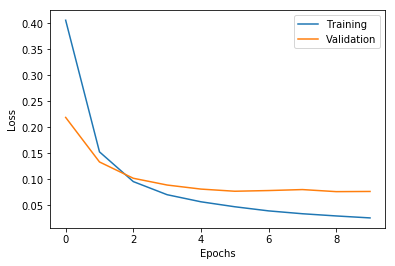

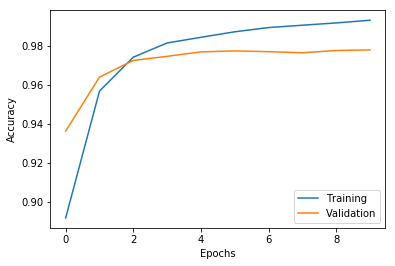

In [18]:
plot_history(hist)

### Task 2: Evaluating - Define an `evaluate` function, with the following properties:
* It takes X_test and Y_test as arguments
* It calculates the loss, the accuracy and the classification report 
* It plots the probability of being a zero for true zeros (red) and non-zeros (blue)
* It computes and plots the confusion matrix
* It plots the image, the prediction and the true value for the top 6 errors
* It plots image and predictions for the first 15 examples

In [19]:
from sklearn.metrics import confusion_matrix,classification_report

def evaluate(X_test, Y_test):
    
    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_cls = np.argmax(Y_pred, axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test, axis = 1) 
    print 'Classification Report:\n', classification_report(Y_true,Y_cls)
    
    ## Plot 0 probability
    label=0
    Y_pred_prob = Y_pred[:,label]
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', bins=10, log = True)
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue', bins=10, log = True)
    plt.legend(['digit == 0', 'digit != 0'], loc='upper right')
    plt.xlabel('Probability of being 0')
    plt.ylabel('Number of entries')
    plt.show()
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls) 
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(confusion_mtx, classes = range(10))

    #Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    # Sorted list of the delta prob errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors 
    most_important_errors = sorted_dela_errors[-6:]
    # Show the top 6 errors
    display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors)
    
    ##Plot predictions
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)
    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test[i].reshape(28,28), interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

('Test Loss:', 0.06558480308502912)
('Test Accuracy:', 0.9805)
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.98      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



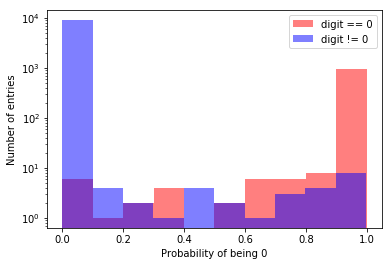

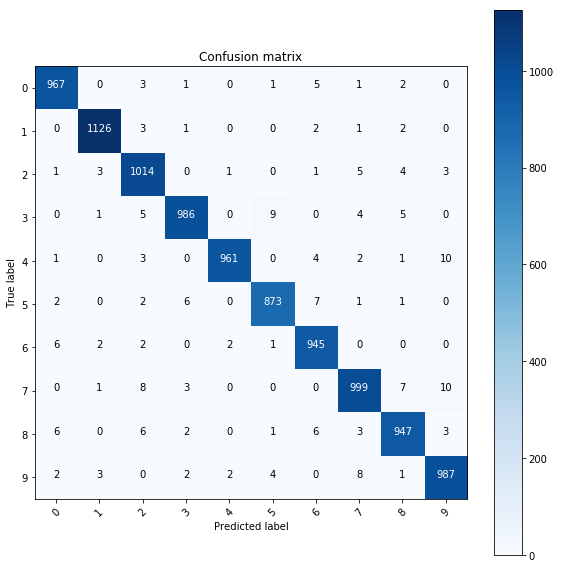

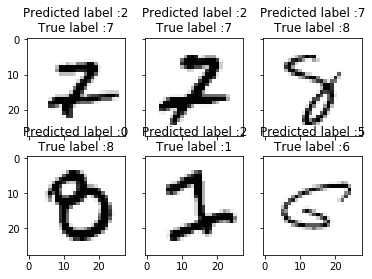

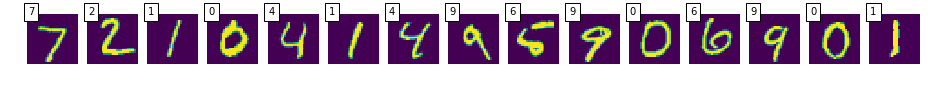

In [20]:
evaluate(X_test, Y_test)

## Adding more Dense Layers and Dropout

### Task 3: Adding additional classification layers
* Add a dense layer between the flatten layer and the output layer 
* Add a 25% dropout layer before the flatten layer
* Add a 50% dropout layer between the two dense layers
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [21]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=shape_ord))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Tra

### Training

In [22]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 70s 2ms/step - loss: 0.4081 - acc: 0.8765 - val_loss: 0.1432 - val_acc: 0.9579
Epoch 2/10
42000/42000 [==============================] - 69s 2ms/step - loss: 0.1611 - acc: 0.9527 - val_loss: 0.0880 - val_acc: 0.9742
Epoch 3/10
42000/42000 [==============================] - 63s 2ms/step - loss: 0.1095 - acc: 0.9667 - val_loss: 0.0741 - val_acc: 0.9784
Epoch 4/10
42000/42000 [==============================] - 66s 2ms/step - loss: 0.0824 - acc: 0.9745 - val_loss: 0.0651 - val_acc: 0.9806
Epoch 5/10
42000/42000 [==============================] - 68s 2ms/step - loss: 0.0684 - acc: 0.9784 - val_loss: 0.0645 - val_acc: 0.9809
Epoch 6/10
42000/42000 [==============================] - 62s 1ms/step - loss: 0.0589 - acc: 0.9811 - val_loss: 0.0626 - val_acc: 0.9813
Epoch 7/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.0511 - acc: 0.9834 - val_loss: 0.0586 - val_acc

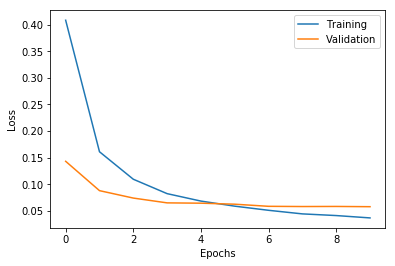

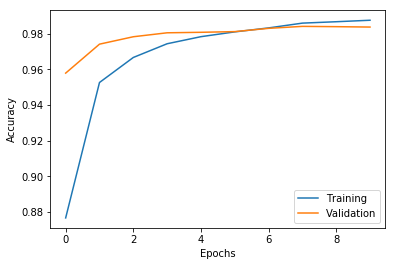

In [23]:
plot_history(hist)

### Evaluating

('Test Loss:', 0.04608184394863056)
('Test Accuracy:', 0.9845)
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



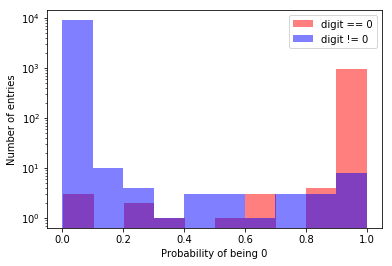

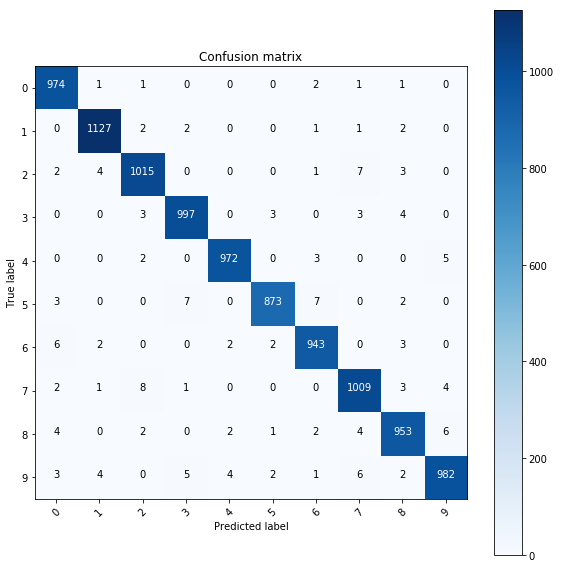

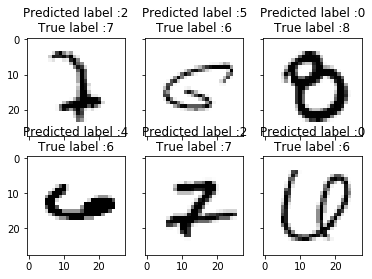

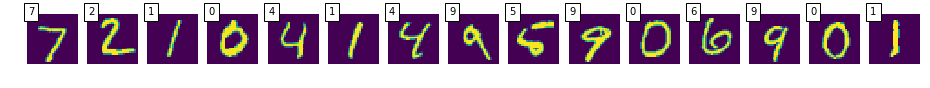

In [24]:
# Evaluating the model on the test data    
evaluate(X_test, Y_test)

# Adding an additional convolution layer and a pooling layer

### Task 3: Adding additional classification layers
* Add another `Conv2D` layer after the first convolutional layer with 64 filter, 3x3 kernel and `valid` (no) padding
* Add another `MaxPooling2D` layer with a 2x2 pooling size 
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [25]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=shape_ord))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

### Training

In [26]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 103s 2ms/step - loss: 0.3555 - acc: 0.8910 - val_loss: 0.0928 - val_acc: 0.9716
Epoch 2/10
42000/42000 [==============================] - 110s 3ms/step - loss: 0.1085 - acc: 0.9674 - val_loss: 0.0629 - val_acc: 0.9801
Epoch 3/10
42000/42000 [==============================] - 135s 3ms/step - loss: 0.0759 - acc: 0.9772 - val_loss: 0.0490 - val_acc: 0.9849
Epoch 4/10
42000/42000 [==============================] - 101s 2ms/step - loss: 0.0621 - acc: 0.9812 - val_loss: 0.0456 - val_acc: 0.9862
Epoch 5/10
42000/42000 [==============================] - 94s 2ms/step - loss: 0.0541 - acc: 0.9830 - val_loss: 0.0408 - val_acc: 0.9877
Epoch 6/10
42000/42000 [==============================] - 98s 2ms/step - loss: 0.0466 - acc: 0.9857 - val_loss: 0.0420 - val_acc: 0.9878
Epoch 7/10
42000/42000 [==============================] - 89s 2ms/step - loss: 0.0376 - acc: 0.9881 - val_loss: 0.0429 - val

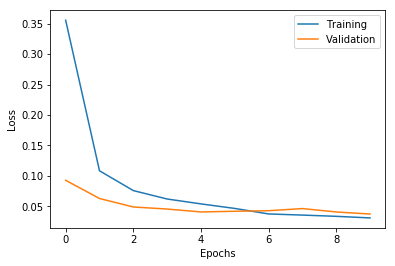

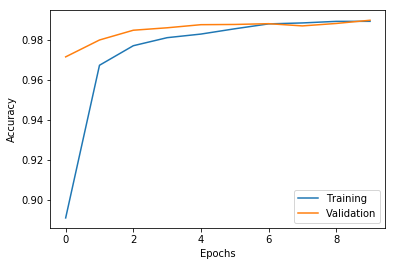

In [27]:
plot_history(hist)

### Evaluating

('Test Loss:', 0.030270598501911446)
('Test Accuracy:', 0.9915)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



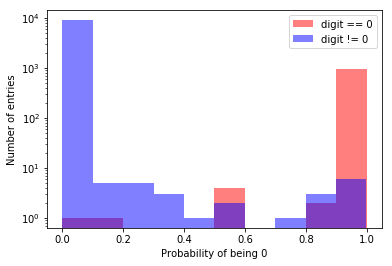

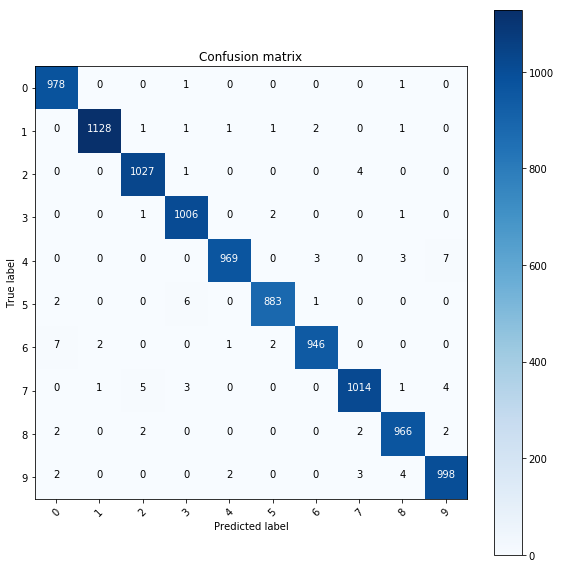

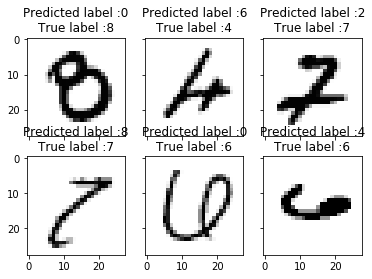

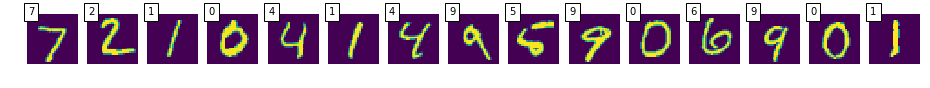

In [28]:
evaluate(X_test, Y_test)

---

# Bonus: Understanding Convolutional Layers Structure

We will inspect and understand the convolutional layer of our previously defined quite shallow CNN, which contains two [Convolution, Convolution, MaxPooling] stages, and two Dense layers.


### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user). 

In this case, it is a `28x28` image with three color channels. 

Since this convolutional layer has the `padding` set to `same`, its output width and height will remain the same, and the number of output channel will be equal to the number of filters learned by the layer, 16. 

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel. 

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels. 

`Activation` layers, of course, don't change the shape.

In [29]:
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

('Layer', 0, '\t', 'conv2d_3', '\t\t', (None, 28, 28, 1), '\t', (None, 26, 26, 32))
('Layer', 1, '\t', 'conv2d_4', '\t\t', (None, 26, 26, 32), '\t', (None, 24, 24, 64))
('Layer', 2, '\t', 'max_pooling2d_1', '\t\t', (None, 24, 24, 64), '\t', (None, 12, 12, 64))
('Layer', 3, '\t', 'dropout_3', '\t\t', (None, 12, 12, 64), '\t', (None, 12, 12, 64))
('Layer', 4, '\t', 'flatten_3', '\t\t', (None, 12, 12, 64), '\t', (None, 9216))
('Layer', 5, '\t', 'dense_4', '\t\t', (None, 9216), '\t', (None, 128))
('Layer', 6, '\t', 'dropout_4', '\t\t', (None, 128), '\t', (None, 128))
('Layer', 7, '\t', 'dense_5', '\t\t', (None, 128), '\t', (None, 10))


### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer. 

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object. 

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters. 


- **Convolutional layers**, instead, learn a $(n_o, n_i, k, k)$ weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned. 

For each of the $n_o$ filters, a bias is also learned. 


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [30]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

('Layer', 0, '\t', 'conv2d_3', '\t\t', (3, 3, 1, 32), '\t', (32,))
('Layer', 1, '\t', 'conv2d_4', '\t\t', (3, 3, 32, 64), '\t', (64,))
('Layer', 5, '\t', 'dense_4', '\t\t', (9216, 128), '\t', (128,))
('Layer', 7, '\t', 'dense_5', '\t\t', (128, 10), '\t', (10,))
